In [1]:
import numpy as np
from numpy import cos, sin
import matplotlib.pyplot as plt
from qiskit.quantum_info import (
    Statevector,
    state_fidelity,
    Operator,
    average_gate_fidelity,
)
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import RXGate, CXGate

i = 1j

In [2]:
def cycle_circuit(ϕ, γ):
    qc = QuantumCircuit(2)
    qc.append(RXGate(ϕ), [0])
    qc.append(RXGate(γ * ϕ), [1])
    qc.append(CXGate(), [0, 1])
    return qc


def ideal_cycle(ϕ):
    qc = QuantumCircuit(2)
    qc.append(RXGate(ϕ), [0])
    qc.append(CXGate(), [0, 1])
    return qc


def full_circuit(ϕ, γ, n, initial_state=Statevector.from_int(0, dims=(2, 2))):
    qc = QuantumCircuit(2)
    qc.prepare_state(initial_state)
    for _ in range(n):
        qc.compose(cycle_circuit(ϕ, γ), inplace=True)
    return qc


def ideal_full_circuit(ϕ, n, initial_state=Statevector.from_int(0, dims=(2, 2))):
    qc = QuantumCircuit(2)
    qc.prepare_state(initial_state)
    for _ in range(n):
        qc.compose(ideal_cycle(ϕ), inplace=True)
    return qc


def inverse_unitary(qc: QuantumCircuit):
    return Operator(qc.inverse())

In [ ]:
def alpha_prime(α, β, τ, δ, ϕ, γ):
    return (
        α * cos(ϕ / 2) * cos(γ * ϕ / 2)
        - i * β * cos(ϕ / 2) * sin(γ * ϕ / 2)
        - i * τ * sin(ϕ / 2) * cos(γ * ϕ / 2)
        - δ * sin(ϕ / 2) * sin(γ * ϕ / 2)
    )


def beta_prime(α, β, τ, δ, ϕ, γ):
    return (
        -i * α * sin(γ * ϕ / 2) * cos(ϕ / 2)
        + β * cos(γ * ϕ / 2) * cos(ϕ / 2)
        - τ * sin(γ * ϕ / 2) * sin(ϕ / 2)
        - i * δ * cos(γ * ϕ / 2) * sin(ϕ / 2)
    )


def tau_prime(α, β, τ, δ, ϕ, γ):
    return (
        -α * sin(ϕ / 2) * sin(γ * ϕ / 2)
        - i * β * sin(ϕ / 2) * cos(γ * ϕ / 2)
        - i * τ * sin(γ * ϕ / 2) * cos(ϕ / 2)
        + δ * cos(ϕ / 2) * cos(γ * ϕ / 2)
    )


def delta_prime(α, β, τ, δ, ϕ, γ):
    return (
        -i * α * sin(ϕ / 2) * cos(γ * ϕ / 2)
        - β * sin(ϕ / 2) * sin(γ * ϕ / 2)
        + τ * cos(ϕ / 2) * cos(γ * ϕ / 2)
        - i * δ * sin(γ * ϕ / 2) * cos(ϕ / 2)
    )


def new_state(α, β, τ, δ, ϕ, γ):
    return (
        alpha_prime(α, β, τ, δ, ϕ, γ),
        beta_prime(α, β, τ, δ, ϕ, γ),
        tau_prime(α, β, τ, δ, ϕ, γ),
        delta_prime(α, β, τ, δ, ϕ, γ),
    )


def analytic_spillover(α, β, τ, δ, ϕ, γ, n):
    for _ in range(n):
        α, β, τ, δ = new_state(α, β, τ, δ, ϕ, γ)

    final_state = Statevector([α, β, τ, δ], dims=(2, 2)).reverse_qargs()
    assert (
        final_state.is_valid()
    ), f"Final state is not valid: norm {np.linalg.norm(final_state.data)}"
    return Statevector([α, β, τ, δ], dims=(2, 2)).reverse_qargs()


def symbolic_spillover(α, β, τ, δ, ϕ, γ, n):
    for _ in range(n):
        α, β, τ, δ = new_state(α, β, τ, δ, ϕ, γ)

    return α, β, τ, δ

In [ ]:
# Define the number of cycles
n = 4

# Define the cycle circuit parameters
ϕ = np.pi / 2
γ = 0.1

# Define the initial state
α = 1.0
β = 0.0
τ = 0.0
δ = 0.0

statevector = Statevector([α, β, τ, δ], dims=(2, 2))
assert statevector.is_valid()
print(statevector)

In [ ]:
from qiskit.circuit import Parameter

α_p = Parameter("α")
β_p = Parameter("β")
τ_p = Parameter("τ")
δ_p = Parameter("δ")
ϕ_p = Parameter("ϕ")
γ_p = Parameter("γ")

α_new, β_new, τ_new, δ_new = symbolic_spillover(α_p, β_p, τ_p, δ_p, ϕ_p, γ_p, n)

In [ ]:
from sympy import latex, sympify

print(α_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ}).sympify().simplify())
print(β_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ}).sympify().simplify())
print(τ_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ}).sympify().simplify())
print(δ_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ}).sympify().simplify())

In [ ]:
print(
    latex(
        sympify(α_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ}).sympify().simplify()),
        symbol_names={
            "α": r"\alpha",
            "β": r"\beta",
            "τ": r"\tau",
            "δ": r"\delta",
            "γ": r"\gamma",
            "ϕ": r"\phi",
        },
    )
)

In [ ]:
α_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ}).sympify()

In [ ]:
analytic_state = analytic_spillover(α, β, τ, δ, ϕ, γ, n)
analytic_state

In [ ]:
circuit_state = Statevector(full_circuit(ϕ, γ, n, statevector))

In [ ]:
circuit_state.equiv(analytic_state)

In [ ]:
from qiskit.quantum_info import Operator

repetitions = np.arange(1, 200)
fidelities1 = []
fidelities2 = []
fidelities3 = []
distances = []
zero_state = Statevector.from_int(0, dims=(2, 2))
for n in repetitions:
    analytic_state = analytic_spillover(α, β, τ, δ, ϕ, γ, n)
    circuit_op = Operator(full_circuit(ϕ, γ, n, statevector))
    ideal_state = Statevector(ideal_full_circuit(ϕ, n, statevector))
    ideal_reverse_unitary = inverse_unitary(ideal_full_circuit(ϕ, n, statevector))
    fidelities1.append(state_fidelity(circuit_state, ideal_state))
    fidelities2.append(state_fidelity(analytic_state, ideal_state))
    fidelities3.append(state_fidelity(analytic_state.evolve(ideal_reverse_unitary), zero_state))


plt.plot(repetitions, fidelities1, "o", label="Qiskit Statevector")
plt.plot(repetitions, fidelities2, "x", label="Analytic Statevector")
plt.plot(
    repetitions,
    fidelities3,
    "s",
    label="Analytic Statevector (evolved with inverse ideal unitary)",
)
plt.xlabel("Number of cycles")
plt.ylabel("State fidelity")
plt.title("State fidelity between circuit and ideal state")

In [ ]:
γ_values = np.linspace(0, 0.1, 100)
fidelities1 = []
fidelities2 = []
fidelities3 = []
for γ in γ_values:
    analytic_state = analytic_spillover(α, β, τ, δ, ϕ, γ, n)
    circuit_state = Statevector(full_circuit(ϕ, γ, n, statevector))
    ideal_state = Statevector(ideal_full_circuit(ϕ, n, statevector))
    fidelities1.append(state_fidelity(circuit_state, ideal_state))
    fidelities2.append(state_fidelity(analytic_state, ideal_state))
    fidelities3.append(state_fidelity(analytic_state.evolve(ideal_reverse_unitary), zero_state))

plt.plot(γ_values, fidelities1, "o-", label="Qiskit Statevector")
plt.plot(γ_values, fidelities2, "x-", label="Analytic Statevector")
plt.plot(
    γ_values,
    fidelities3,
    "s-",
    label="Analytic Statevector (evolved with inverse ideal unitary)",
)
plt.xlabel("γ")
plt.ylabel("State fidelity")
plt.title("State fidelity between circuit and ideal state")
plt.legend()

# Unitary computation

In [ ]:
from qiskit.circuit import Parameter
from qiskit.quantum_info import Operator, average_gate_fidelity
from qiskit_symb.quantum_info import Operator as SymbOperator
from numpy import cos, sin

ϕ = Parameter("ϕ")
γ = Parameter("γ")
α = cos(ϕ / 2) * cos(γ * ϕ / 2)
β = -1j * sin(γ * ϕ / 2) * cos(ϕ / 2)
τ = -1j * sin(ϕ / 2) * cos(γ * ϕ / 2)
δ = -sin(ϕ / 2) * sin(γ * ϕ / 2)

In [ ]:
# First order development
α = cos(ϕ / 2) * (1 - γ**2 * ϕ**2 / 8)
β = -1j * γ * ϕ / 2 * cos(ϕ / 2)
τ = -1j * sin(ϕ / 2) * (γ * ϕ / 2)
δ = -sin(ϕ / 2) * (γ * ϕ / 2)

In [ ]:
def cycle_circuit_unitary(ϕ, γ):
    qc = cycle_circuit(ϕ, γ)
    return Operator(qc).reverse_qargs()


def ideal_cycle_unitary(ϕ):
    qc = ideal_cycle(ϕ)
    return Operator(qc).reverse_qargs()


def full_circuit_unitary(ϕ, γ, n):
    qc = full_circuit(ϕ, γ, n)
    return Operator(qc).reverse_qargs()


def ideal_full_circuit_unitary(ϕ, n):
    qc = ideal_full_circuit(ϕ, n)
    return Operator(qc).reverse_qargs()


def analytic_spillover_unitary(ϕ, γ):
    α = cos(ϕ / 2) * cos(γ * ϕ / 2)
    β = -1j * sin(γ * ϕ / 2) * cos(ϕ / 2)
    τ = -1j * sin(ϕ / 2) * cos(γ * ϕ / 2)
    δ = -sin(ϕ / 2) * sin(γ * ϕ / 2)

    return Operator(np.array([[α, β, τ, δ], [β, α, δ, τ], [δ, τ, β, α], [τ, δ, α, β]]))


def analytic_ideal_unitary(ϕ):
    return analytic_spillover_unitary(ϕ, 0)


γ_val = 0.1
ϕ_val = np.pi / 2
qiskit_unitary = cycle_circuit_unitary(ϕ_val, γ_val)
analytic_unitary = analytic_spillover_unitary(ϕ_val, γ_val)

In [ ]:
symb_op = SymbOperator([[α, β, τ, δ], [β, α, δ, τ], [δ, τ, β, α], [τ, δ, α, β]])

In [ ]:
import sympy as sp

symb_op2 = sp.Matrix(symb_op.to_sympy())
n = sp.Symbol("n", integer=True)
eigen_vals = symb_op2.eigenvals()
P, D = symb_op2.diagonalize()
P

# Noisy backend simulation

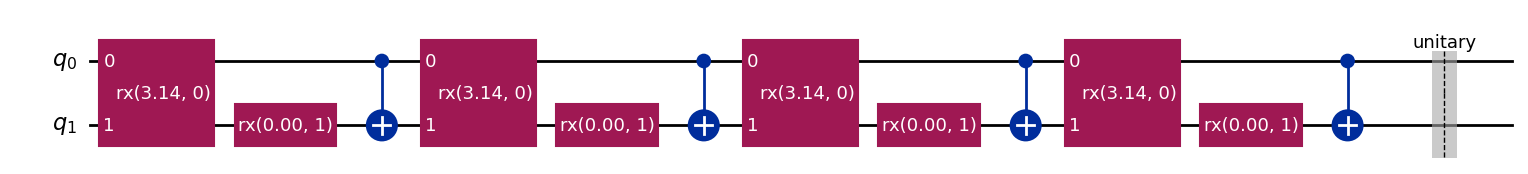

In [2]:
from gate_level.spillover_noise_use_case.generic_spillover.spillover_effect_on_subsystem import (
    noisy_backend,
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
)
from qiskit.transpiler import PassManager
from qiskit_aer import AerSimulator
from qiskit.quantum_info import average_gate_fidelity

# Define the number of cycles
n = 4

# Define the cycle circuit parameters
ϕ = np.pi
γ = 0.1

γ_matrix = lambda γ: np.array([[0, γ], [0, 0]])
ref_circ = lambda ϕ: circuit_context(2, ["rx", "rx"], [ϕ, 0.0])


def cycle_circuit(circuit, γ, n=1):
    qc = QuantumCircuit(2)
    for _ in range(n):
        qc.compose(circuit, inplace=True)
    qc.save_unitary()
    pm = PassManager(
        [
            LocalSpilloverNoiseAerPass(
                spillover_rate_matrix=numpy_to_hashable(γ_matrix(γ)),
                target_subsystem=(0, 1),
            )
        ]
    )
    qc = pm.run(qc)
    return qc


qc = cycle_circuit(ref_circ(ϕ), γ, n)
qc.draw("mpl")

In [4]:
backend = noisy_backend(ref_circ(ϕ), γ_matrix(γ), target_subsystem=(0, 1))
backend.options.noise_model

<NoiseModel on ['rx(0.00, 1)']>

In [ ]:
gate_fidelities = []
γ_range = np.linspace(0, 10, 200)
n = 1
for γ in γ_range:
    qc = cycle_circuit(ref_circ(ϕ), γ, n)
    backend = noisy_backend(ref_circ(ϕ), np.array([[0, γ], [0, 0]]), target_subsystem=(0, 1))
    noisy_unitary = backend.run(qc).result().get_unitary()
    ideal_unitary = AerSimulator().run(qc).result().get_unitary()
    gate_fidelities.append(average_gate_fidelity(noisy_unitary, ideal_unitary))

plt.plot(γ_range, gate_fidelities, "o-")
plt.xlabel("γ")
plt.ylabel("Average gate fidelity")
plt.title(f"Average gate fidelity for different values of γ (params: ϕ={ϕ}, n={n})")

In [ ]:
# Heatmap for fidelity: γ and ϕ
ϕ_range = np.linspace(0, np.pi, 20)
γ_range = np.linspace(0, 1, 10)
fidelities = np.zeros((20, 10))
for i, ϕ in enumerate(ϕ_range):
    for j, γ in enumerate(γ_range):
        qc = cycle_circuit(ref_circ(ϕ), γ, n)
        backend = noisy_backend(ref_circ(ϕ), γ_matrix(γ), target_subsystem=(0, 1))
        noisy_unitary = backend.run(qc).result().get_unitary()
        ideal_unitary = AerSimulator().run(qc).result().get_unitary()
        fidelities[i, j] = average_gate_fidelity(noisy_unitary, ideal_unitary)

plt.imshow(fidelities, extent=(γ_range[0], γ_range[-1], ϕ_range[0], ϕ_range[-1]), aspect="auto")
plt.colorbar()
plt.xlabel("γ")
plt.ylabel("ϕ")
plt.title("Average gate fidelity")

In [ ]:
# Heatmap for fidelity: γ and n
n_range = range(1, 30)
γ_range = np.linspace(0, 0.2, 50)
fidelities = np.zeros((50, 30))
for i, γ in enumerate(γ_range):
    for j, n in enumerate(n_range):
        qc = cycle_circuit(ref_circ(ϕ), γ, n)
        backend = noisy_backend(ref_circ(ϕ), np.array([[0, γ], [0, 0]]), target_subsystem=(0, 1))
        noisy_unitary = backend.run(qc).result().get_unitary()
        ideal_unitary = AerSimulator().run(qc).result().get_unitary()
        fidelities[i, j] = average_gate_fidelity(noisy_unitary, ideal_unitary)


plt.imshow(fidelities, extent=(n_range[0], n_range[-1], γ_range[0], γ_range[-1]), aspect="auto")
plt.colorbar()
plt.xlabel("n")
plt.ylabel("γ")
plt.title(f"Average gate fidelity (params: ϕ={ϕ})")

Text(0.5, 1.0, 'Average gate fidelity (params: γ=0.1)')

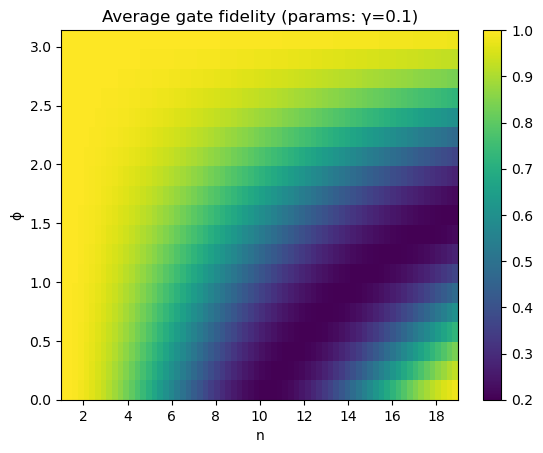

In [11]:
# Heatmap for fidelity: ϕ and n
n_range = np.arange(1, 20)
ϕ_range = np.linspace(0, np.pi, 70)

fidelities = np.zeros((ϕ_range.size, n_range.size))
γ = 0.1
for i, ϕ in enumerate(ϕ_range):
    for j, n in enumerate(n_range):
        qc = cycle_circuit(ref_circ(ϕ), γ, n)
        backend = noisy_backend(ref_circ(ϕ), γ_matrix(γ), target_subsystem=(0, 1))
        noisy_unitary = backend.run(qc).result().get_unitary()
        ideal_unitary = AerSimulator().run(qc).result().get_unitary()
        fidelities[i, j] = average_gate_fidelity(noisy_unitary, ideal_unitary)

plt.imshow(
    fidelities.T,
    extent=(n_range[0], n_range[-1], ϕ_range[0], ϕ_range[-1]),
    aspect="auto",
)
plt.colorbar()
plt.xlabel("n")
plt.ylabel("ϕ")
plt.title(f"Average gate fidelity (params: γ={γ})")

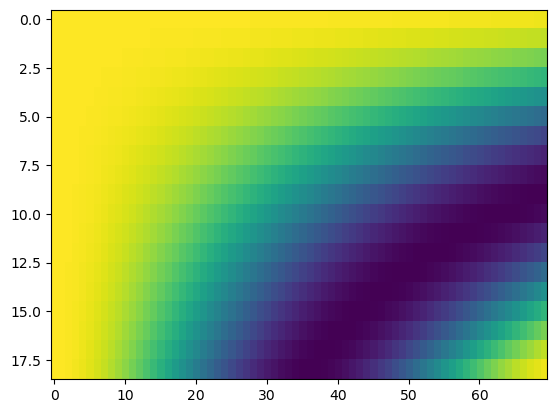

In [12]:
plt.imshow(fidelities.T, aspect="auto")

ValueError: x and y must have same first dimension, but have shapes (70,) and (19,)

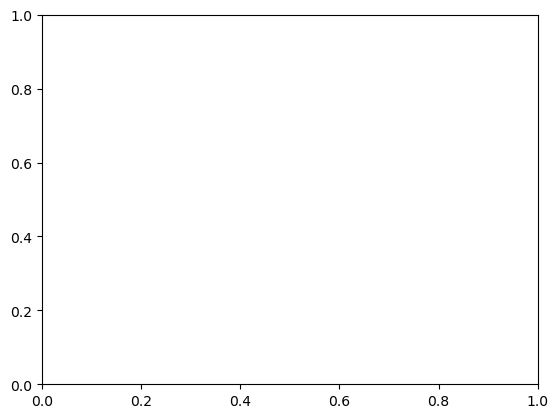

In [10]:
plt.plot(ϕ_range, fidelities[-1, :], "o-")

Text(0.5, 1.0, 'Average gate fidelity for different number of cycles (params: ϕ=3.141592653589793, γ=0.1)')

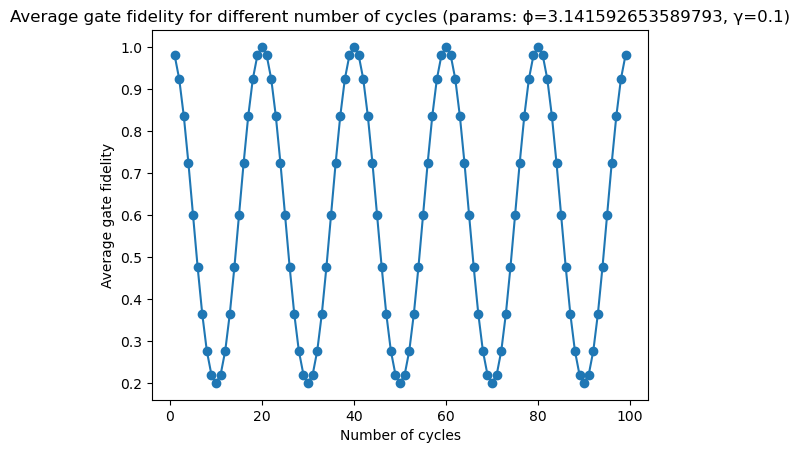

In [5]:
gate_fidelities = []
n_range = range(1, 100)
for n in n_range:
    qc = cycle_circuit(ref_circ(ϕ), γ, n)
    backend = noisy_backend(ref_circ(ϕ), γ_matrix(γ), target_subsystem=(0, 1))
    noisy_unitary = backend.run(qc).result().get_unitary()
    ideal_unitary = AerSimulator().run(qc).result().get_unitary()
    gate_fidelities.append(average_gate_fidelity(noisy_unitary, ideal_unitary))

plt.plot(n_range, gate_fidelities, "o-")
plt.xlabel("Number of cycles")
plt.ylabel("Average gate fidelity")
plt.title(f"Average gate fidelity for different number of cycles (params: ϕ={ϕ}, γ={γ})")